In [58]:
import sqlite3
import itertools
import numpy as np
import matplotlib.pyplot as plt

Notebook to get various metrics to from a AOSP project, which are:
- Number of AOCs
- Types of AOCs
- AOCs per Class
- AOCs per File
- AOCs per LOC (file-wise)
- AOCs per LOC (repo-wise)
- AOCs per repo

In [2]:
connection = sqlite3.connect("../aosp_ck_output.db")

In [92]:
def get_projects():
    # the files table has more projects than the project table
    cursor = connection.execute("SELECT DISTINCT project_name FROM files")
    return [elem[0] for elem in cursor]

def report_types_of_aocs(project_name) -> dict:
    sql = f"SELECT aoc, count(id) as qty FROM aoc_reports WHERE project_name LIKE '{project_name}' GROUP BY aoc ORDER BY qty DESC"
    cursor = connection.execute(sql)
    output = {}
    for aoc_type, count in cursor:
        output[aoc_type] = count
    return output

def report_aocs_per_file(project_name) -> float:
    sql = f"SELECT ( qty_aocs  * 1.0)/qty_files FROM (SELECT count(path) as qty_files FROM files WHERE project_name LIKE '{project_name}'), (SELECT count(id) as qty_aocs FROM aoc_reports WHERE project_name LIKE '{project_name}')"
    cursor = connection.execute(sql)
    return next(cursor)[0]

def report_aocs_per_loc_filewise(project_name) -> dict:
    sql = f"SELECT files_path, ((loc * 1.0) / qty_aocs) as aocs_per_loc FROM (SELECT path as aoc_repors_path, count(id) as qty_aocs FROM aoc_reports WHERE project_name LIKE '{project_name}' GROUP BY path ORDER BY qty_aocs DESC), (SELECT path as files_path, loc FROM files WHERE project_name LIKE '{project_name}') WHERE aoc_repors_path == files_path ORDER BY aocs_per_loc ASC"
    cursor = connection.execute(sql)
    output = {}
    for file_path, aocs_per_loc in cursor:
        output[file_path] = aocs_per_loc
    return output

def report_aocs_per_loc(file_name) -> float:
    sql= f"SELECT loc from files WHERE path = '{file_name}'"
    loc = next(connection.execute(sql))[0]
    sql = f"SELECT count(id) from aoc_reports WHERE path = '{file_name}'"
    aocs = next(connection.execute(sql))[0]
    return loc / aocs

def report_aocs_per_loc_repowise() -> dict:
    sql = "SELECT files_project_name, ((sum_locs * 1.0) / qty_aocs) AS aocs_per_loc FROM (SELECT project_name as files_project_name, sum(loc) as sum_locs FROM files GROUP BY project_name), (SELECT project_name as aoc_reports_project_name, count(id) as qty_aocs FROM aoc_reports GROUP BY project_name) WHERE files_project_name = aoc_reports_project_name ORDER BY aocs_per_loc"
    cursor = connection.execute(sql)
    output = {}
    for proj_name, aocs_per_loc in cursor:
        output[proj_name] = aocs_per_loc
    return output

def report_aocs_per_repo(project_name) -> float:
    sql = f"SELECT count(id) FROM aoc_reports WHERE project_name = '{project_name}'"
    cursor = connection.execute(sql)
    return next(cursor)[0]


def report_aocs_per_repo_aospwise():
    sql = "SELECT project_name, count(id) as qty_aocs FROM aoc_reports GROUP BY project_name ORDER BY qty_aocs DESC"
    cursor = connection.execute(sql)
    output = {}
    for proj_name, aoc_count in cursor:
        output[proj_name] = aoc_count
    return output

def report_number_of_files(project_name) -> int:
    sql = f"SELECT count(path) FROM files WHERE project_name = '{project_name}'"
    cursor = connection.execute(sql)
    return next(cursor)[0]

def report_files_with_aocs(project_name) -> list:
    sql = f"SELECT DISTINCT path FROM aoc_reports WHERE project_name = '{project_name}'"
    cursor = connection.execute(sql)
    return [tup[0] for tup in cursor]

def report_files_without_aocs(project_name) -> list:
    sql = f"SELECT path FROM files WHERE project_name = '{project_name}'"
    cursor = connection.execute(sql)
    all_files = [tup[0] for tup in cursor]
    files_with_aoc = report_files_with_aocs(project_name)
    return [file for file in all_files if file not in files_with_aoc]

def get_aocs(file_name) -> list:
    sql = f"SELECT * from aoc_reports WHERE path = '{file_name}'"
    cursor = connection.execute(sql)
    return [tuple(tup) for tup in cursor]

def report_number_of_aocs_in_files(project_name) -> dict:
    sql = f"""
    SELECT files.path, coalesce(aoc_count, 0) AS count_aocs
    FROM files
    LEFT JOIN
    (SELECT aoc_reports.path AS aoc_reports_path, count(id) AS aoc_count
    FROM aoc_reports
    WHERE project_name = '{project_name}'
    GROUP BY aoc_reports.path)
    ON files.path = aoc_reports_path
    WHERE files.project_name = '{project_name}'
    ORDER BY count_aocs DESC;
    """
    cursor = connection.execute(sql)
    return {k: v for k,v in cursor}

def report_cdf_curve_presence_of_aocs(project_name) -> np.array:
    aocs_amt = [x for x in reversed(report_number_of_aocs_in_files(project_name).values())]
    return np.cumsum(aocs_amt)


def report_list_of_repos() -> list:
    sql = "SELECT name FROM projects"
    cursor = connection.execute(sql)
    return [tup[0] for tup in cursor]


def make_report(project_name):
    report = []
    report.append(f"Report for {project_name}")
    report.append("")
    report.append("TYPE OF AOCS")
    report.append("")
    for k,v in report_types_of_aocs(project_name).items():
        report.append(f"{k}: {v}")
    report.append("")
    report.append("Atom rate per Line of Code (Top 5 files)")
    for k,v in itertools.islice(report_aocs_per_loc_filewise(project_name).items(), 5):
        report.append(f"{k}: {v}")
    report.append("")
    report.append("General Metrics")
    report.append("")
    report.append(f"Number of Atoms: {report_aocs_per_repo(project_name)}")
    report.append(f"Atom rate per Line of Code (repo wise): {report_aocs_per_loc_repowise()[project_name]}")
    report.append(f"Files with at least one atom: {len(report_files_with_aocs(project_name))}")
    report.append(f"Files without atoms: {len(report_files_without_aocs(project_name))}")
    report.append(f"Number of java files: {report_number_of_files(project_name)}")
    return "\n".join(report)


In [68]:
print(make_report('external/grpc-grpc-java'))

Report for external/grpc-grpc-java

TYPE OF AOCS

Logic as Control Flow: 629
Conditional Operator: 376
Type Conversion: 130
Infix Operator Precedence: 129
Post Increment Decrement: 61
Pre Increment Decrement: 33
Change of Literal Encoding: 11
Repurposed Variables: 3

Atom rate per Line of Code (Top 5 files)
/mnt/4846A54B46A53A98/AOSP/external/grpc-grpc-java/alts/src/test/java/io/grpc/alts/internal/AltsChannelCrypterTest.java: 8.882352941176471
/mnt/4846A54B46A53A98/AOSP/external/grpc-grpc-java/netty/src/jmh/java/io/grpc/netty/InboundHeadersBenchmark.java: 9.3
/mnt/4846A54B46A53A98/AOSP/external/grpc-grpc-java/xds/src/test/java/io/grpc/xds/WeightedRoundRobinLoadBalancerTest.java: 15.803571428571429
/mnt/4846A54B46A53A98/AOSP/external/grpc-grpc-java/xds/src/main/java/io/grpc/xds/RoutingUtils.java: 16.0
/mnt/4846A54B46A53A98/AOSP/external/grpc-grpc-java/authz/src/main/java/io/grpc/authz/AuthorizationPolicyTranslator.java: 16.583333333333332

General Metrics

Number of Atoms: 1372
Atom rat

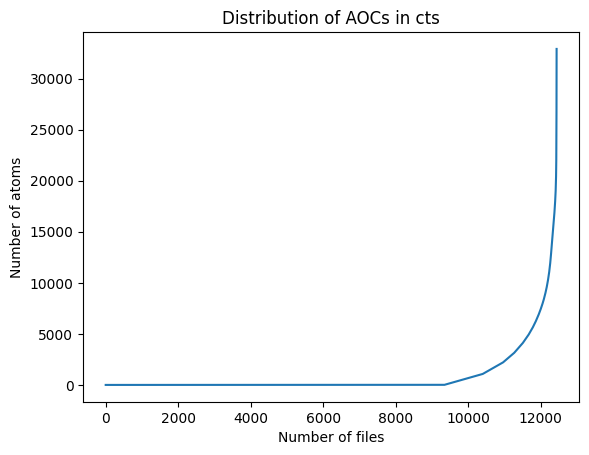

In [97]:
project = 'cts'
cdf = report_cdf_curve_presence_of_aocs(project)
X = np.arange(start = 1, stop = report_number_of_files(project) + 1, step=1)
plt.title(f"Distribution of AOCs in {project}")
plt.xlabel("Number of files")
plt.ylabel("Number of atoms")
plt.plot(X, cdf)

In [ ]:
out = {}
for project_name in report_list_of_repos():
    num_files_with_aocs = len(report_files_with_aocs(project_name))
    num_files = report_number_of_files(project_name)
    percentage = num_files_with_aocs / num_files
    out[project_name] = num_files
out_sorted = {k: v for k, v in sorted(out.items(), key=lambda item: item[1])}


In [74]:
{k: v for k, v in sorted(out.items(), key=lambda item: item[1], reverse=True)}

{'cts': 12437,
 'packages/apps/Settings': 4424,
 'external/mockftpserver': 3542,
 'external/guava': 3210,
 'external/exoplayer': 2795,
 'external/bouncycastle': 2680,
 'art': 2612,
 'external/icu': 2301,
 'development': 2141,
 'external/robolectric': 1964,
 'packages/services/Car': 1654,
 'external/dagger2': 1470,
 'tools/tradefederation/core': 1463,
 'external/apache-commons-math': 1447,
 'external/javaparser': 1425,
 'packages/modules/AdServices': 1421,
 'external/grpc-grpc-java': 1365,
 'developers/build': 1254,
 'external/robolectric-shadows': 1232,
 'external/testng': 1223,
 'packages/apps/Dialer': 1168,
 'packages/apps/Car/Settings': 1129,
 'platform_testing': 1071,
 'external/jackson-databind': 999,
 'external/smali': 941,
 'packages/apps/Launcher3': 921,
 'external/cronet': 915,
 'packages/modules/Connectivity': 864,
 'packages/modules/Wifi': 853,
 'external/mockito': 849,
 'developers/samples/android': 847,
 'packages/apps/TvSettings': 804,
 'packages/modules/Bluetooth': 787,


In [47]:
print(make_report("external/python/cryptography"))

Report for external/python/cryptography

TYPE OF AOCS

Logic as Control Flow: 1

Atom rate per Line of Code (Top 10 files)
/mnt/4846A54B46A53A98/AOSP/external/python/cryptography/docs/development/custom-vectors/rsa-oaep-sha2/VerifyRSAOAEPSHA2.java: 417.0

General Metrics

Number of Atoms: 1
Atom rate per Line of Code (repo wise): 417.0
Files with at least one atom: 1
Files without atoms: 0
Number of java files: 1


In [ ]:
report_aocs_per_loc('/mnt/4846A54B46A53A98/AOSP/external/grpc-grpc-java/alts/src/test/java/io/grpc/alts/internal/AltsChannelCrypterTest.java')

In [ ]:
report_types_of_aocs('frameworks/native')

In [ ]:
report_aocs_per_file('external/grpc-grpc-java')

In [ ]:
report_aocs_per_loc_filewise('frameworks/native')

In [25]:
{k:v for k,v in report_aocs_per_loc_repowise().items() if k.startswith("external")}

{'external/brotli': 3.5577078288942694,
 'external/conscrypt': 9.142527287993284,
 'external/sonic': 20.892857142857142,
 'external/flatbuffers': 21.15270935960591,
 'external/libese': 21.72460008646779,
 'external/s2-geometry-library-java': 35.14791666666667,
 'external/bouncycastle': 36.90100339732954,
 'external/lzma': 37.27368421052632,
 'external/cbor-java': 37.408256880733944,
 'external/google-smali': 40.361798536075284,
 'external/universal-tween-engine': 41.47787610619469,
 'external/jackson-core': 42.505014749262536,
 'external/noto-fonts': 44.85,
 'external/geojson-jackson': 44.90243902439025,
 'external/owasp/java-encoder': 45.05909090909091,
 'external/smali': 45.23227383863081,
 'external/cldr': 47.82247940368772,
 'external/icu': 48.6857797135288,
 'external/v4l2_codec2': 49.0,
 'external/zxing': 49.617511520737324,
 'external/apache-commons-math': 53.8125,
 'external/mp4parser': 55.189473684210526,
 'external/MPAndroidChart': 56.689473684210526,
 'external/obex': 57.837

In [ ]:
report_aocs_per_loc_filewise('external/brotli')

In [93]:
report_aocs_per_repo_aospwise()

{'frameworks/base': 57387,
 'cts': 32902,
 'external/icu': 22271,
 'libcore': 22116,
 'external/conscrypt': 19056,
 'external/bouncycastle': 12657,
 'external/exoplayer': 10225,
 'packages/modules/Wifi': 7500,
 'external/apache-commons-math': 6352,
 'external/cldr': 5098,
 'packages/apps/Settings': 5024,
 'external/guava': 4885,
 'packages/apps/Launcher3': 3573,
 'frameworks/opt/telephony': 3519,
 'external/google-smali': 2869,
 'external/smali': 2863,
 'packages/modules/Connectivity': 2843,
 'packages/modules/Bluetooth': 2829,
 'external/cronet': 2810,
 'external/javaparser': 2766,
 'external/brotli': 2478,
 'packages/apps/TV': 2397,
 'art': 2355,
 'external/protobuf': 2338,
 'external/libese': 2313,
 'packages/apps/Dialer': 2213,
 'external/robolectric': 2208,
 'development': 2192,
 'packages/services/Car': 2096,
 'external/apache-xml': 1960,
 'external/proguard': 1947,
 'packages/apps/Gallery2': 1821,
 'external/apache-commons-lang': 1799,
 'external/jackson-core': 1695,
 'external/